Britton Lab - 06/09/2023 <br>

Early Polarization - Allan Deviation Plots


<font color='red'>Author: Evan McClintock

# Get Data

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import allantools #https://allantools.readthedocs.io/en/latest/functions.html

def read_pax_data(filename):
    df = pd.read_csv(filepath_or_buffer=filename, delimiter=';', header=7,
                       names=['Timestamp_old', 'Time_Elapsed_old', 's1', 's2', 's3', 'S0', 'S1', 'S2', 'S3',
                             'Azimuth', 'Ellipticity', 'DOP', 'DOCP', 'DOLP', 'Power_total', 'Power_pol', 'Power_unpol',
                             'Power_total_dB', 'Power_pol_dB', 'Power_unpol_dB', 'Power_split_ratio',
                             'Phase_Difference', 'Warning'],
                       dtype={'Timestamp': 'string', 'Time_Elapsed': 'string', 'Warning': 'string'})
    
    df['Timestamp'] = df['Time_Elapsed_old'].apply(lambda string: datetime.datetime.strptime(
        string[string.index('.') + 1:], '%H:%M:%S:%f')) #separate the 'day.' (which causes problems) and convert to datetime
    df['TimeElapsed'] = df['Timestamp'] - df['Timestamp'].iloc[0] #time elapsed since first measurement
    df['TimeElapsed'] = df['TimeElapsed'].dt.total_seconds().astype(float) #convert timedelta to float (seconds)
    
    df = df.drop(columns=['Timestamp_old', 'Time_Elapsed_old', 'Power_total_dB', 'Power_pol_dB',
                                         'Power_unpol_dB', 'Warning'])
    
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    return df

In [122]:
# Read in data, store in pandas DataFrame
filename_steady = "PAX_1_test_steady.csv"
filename_unsteady = "PAX_2_test_unsteady.csv"
filename_steady_long = "PAX_steady_10.csv"
filename_steady_long_3 = "PAX_steady_long_3.csv"
filename_warm = "PAX_warm_10.csv"
filename_cold = "PAX_cold_10.csv"
filename_wound_1 = "PAX_wound_1.csv"
filename_wound_2 = "PAX_wound_2.csv"
filename_wound_slow = "PAX_wound_slow.csv"
filename_wound_slow_2 = "PAX_wound_slow_2.csv"
filename_moving_waveplates = "PAX_moving_waveplates.csv"

df_steady = read_pax_data(filename_steady)
df_unsteady = read_pax_data(filename_unsteady)
df_steady_long = read_pax_data(filename_steady_long)
df_steady_long_3 = read_pax_data(filename_steady_long_3)
df_warm = read_pax_data(filename_warm)
df_cold = read_pax_data(filename_cold)
df_wound_1 = read_pax_data(filename_wound_1)
df_wound_2 = read_pax_data(filename_wound_2)
df_wound_slow = read_pax_data(filename_wound_slow)
df_wound_slow_2 = read_pax_data(filename_wound_slow_2)
df_moving_waveplates = read_pax_data(filename_moving_waveplates)

In [123]:
df_steady_long_3.shape

(29756, 19)

# Plot Dataset Over Time

In [127]:
def plot_pax_params(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,5))

    #plt.plot(df['TimeElapsed'], df['S0'], label='S0', linewidth=1, color='black')
    ax1.plot(df['TimeElapsed'], df['S1'], label='S1', linewidth=1, color='red')
    ax1.plot(df['TimeElapsed'], df['S2'], label='S2', linewidth=1, color='blue')
    ax1.plot(df['TimeElapsed'], df['S3'], label='S3', linewidth=1, color='green')
    ax1.set_ylabel('Stokes param value')
    ax1.set_title('Change in Stokes parameters over time')
    ax1.grid()
    ax1.legend()

    ax2.plot(df['TimeElapsed'], df['Azimuth'], label='Azimuth', linewidth=1, color='orange')
    ax2.plot(df['TimeElapsed'], df['Ellipticity'], label='Ellipticity', linewidth=1, color='m')
    ax2.set_ylabel('Angles [degrees]')
    ax2.set_title('Change in angles over time')
    ax2.grid()
    ax2.legend()

    plt.xlabel('Time [s]')
    plt.tight_layout()
    plt.show()

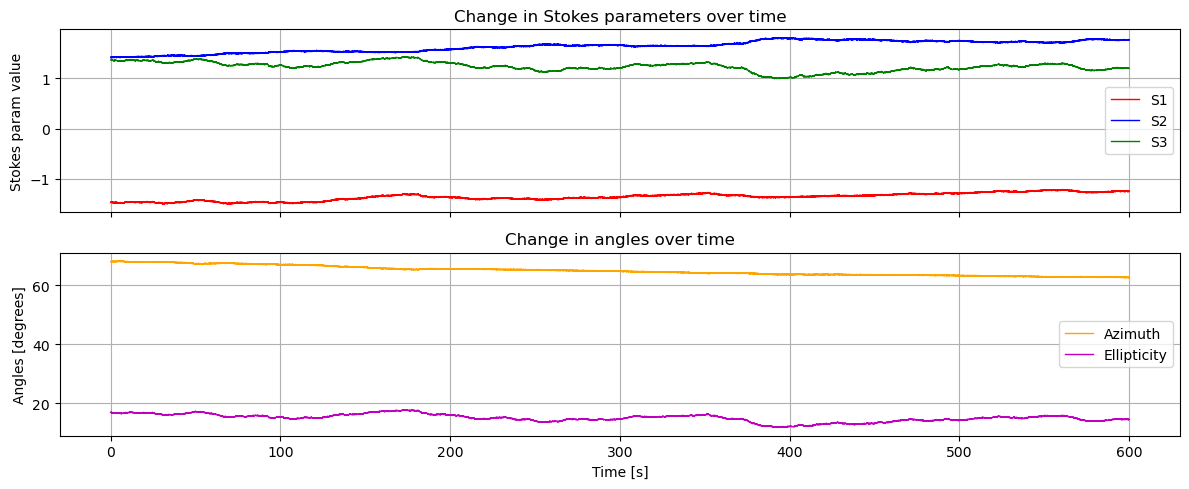

In [128]:
plot_pax_params(df_steady_long)

# Manual Allan Deviation

In [81]:
# Here it is okay to use taus as a parameter, as we will recalculate the actual tau used based on meas_rate
def manual_adev(data, meas_rate, taus):
    N = data.size # number of data points present
    averages = []
    allan_variances = []
    taus_actual = []
    for tau in taus:
        # If tau came from simulation (where tau=num_points/meas_rate), num should be very very close to an integer
        # If tau came from us plugging in chosen values, round is probably best?
        num = round(tau*meas_rate) # number of data points corresponding to sample of length tau
        taus_actual.append(num/meas_rate)
        remainder = N%num # remaining points that are not divisible by num
        if remainder != 0:
            data_cut = data[:-remainder] #cut off remaining points to make array divisible by num
        else:
            data_cut = data #without this, data[:0] will return an empty array
        data_reshaped = data_cut.reshape(-1, num)
        data_averages = np.mean(data_reshaped, axis=1)
        averages.append(data_averages)
        #print('For tau = {:.2f}, array size = {:.2f}'.format(tau,data_averages.size))
        #print('N = {:.2f}, num = {:.2f}, remainder = {:.2f}'.format(N, num, remainder))
        #print('Data cut size = {:.2f}'.format(data_cut.size))
        K = data_averages.size
        diffs = np.diff(data_averages)
        if K!=1:
            var = np.sum(diffs**2) / (2*(K-1))
        else:
            var=0
        allan_variances.append(var)
    return averages, allan_variances, taus_actual

In [142]:
# Here it is okay to use taus as a parameter becuase it's just for plotting purposes; taus isn't passed along anywhere
def plot_adev(averages, allan_variances, taus):
    plt.figure(figsize=(12,5))
    for tau,avg in zip(taus,averages):
        N_avg = avg.size
        #print('For tau = {:.2f}, T = {:.2f}'.format(tau, (N_avg-1) * tau))
        times = np.linspace(0, (N_avg-1) * tau, N_avg) + tau/2
        try:
            plt.plot(times, avg, label = "tau={:.2f}s".format(tau), marker='.')
        except ValueError:
            print('Mismatch of dimensions for tau = {:.2f}'.format(tau))
            print('avg.size = {:d}'.format(N_avg))
            print('Giving np.arange(0, {:.2f}, {:.2f}) + {:.2f}/2'.format(N_avg*tau, tau, tau))
            print('so times.size = {:d}'.format(times.size))
    T = (averages[0].size-1) * taus[0]
    #print(averages[0])
    #print(taus[0])
    #print('For first entry, T = {:.2f}'.format(T))
    plt.xlim(0,T)
    plt.xlabel("Time [s]")
    plt.ylabel("Value")
    plt.title("Data averaged over different times")
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12,3))
    plt.plot(taus, allan_variances, marker='o')
    plt.xlabel("Averaging Time")
    plt.ylabel("Variance")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Variance vs averaging time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return

# Noise Simulation

In [63]:
def generate_white_noise(N, meas_rate, seed=None):
    if seed != None:
        np.random.seed(seed+1) # seed for white noise
    
    white_noise = np.random.normal(0., 1., N) #N normally distributed points
    # As meas_rate increases, the noise on each individual measurement should decrease since we're measuring
    # more times in a single second (taking multiple measurements for (theoretically the same amount of noise)
    # But as T increases, the noise in each measurement shouldn't change, since we're just measuring for longer
    norm_const = np.sqrt(1/meas_rate)
    white_noise *= norm_const # Normalize
    
    return white_noise

def generate_brown_noise(N, meas_rate, seed=None):
    if seed != None:
        np.random.seed(seed+2) # different seed for brown noise
    
    white_noise = np.random.normal(0., 1., N) #N normally distributed points
    # As meas_rate increases, the noise on each individual measurement should decrease since we're measuring
    # more times in a single second (taking multiple measurements for (theoretically the same amount of noise)
    # But as T increases, the noise in each measurement shouldn't change, since we're just measuring for longer
    norm_const = np.sqrt(1/meas_rate)
    white_noise *= norm_const # Normalize
    
    brown_noise = np.cumsum(white_noise) # each random point is a random walk step (cumilate steps)
    
    return brown_noise

def generate_pink_noise(N, meas_rate, seed=None):
    if seed != None:
        np.random.seed(seed+3) # different seed for pink noise
    
    white_noise = np.random.normal(0., 1., N) #N normally distributed points
    # As meas_rate increases, the noise on each individual measurement should decrease since we're measuring
    # more times in a single second (taking multiple measurements for (theoretically the same amount of noise)
    # But as T increases, the noise in each measurement shouldn't change, since we're just measuring for longer
    norm_const = np.sqrt(1/meas_rate)
    white_noise *= norm_const # Normalize
    
    brown_noise = np.cumsum(white_noise) # each random point is a random walk step (cumilate steps)
    
    pink_noise = brown_noise / np.max(np.abs(brown_noise)) #TODO: likely could be wrong
    
    return pink_noise

In [64]:
# We choose a paradigm of using N and meas_rate, and calculating T, since N is the main thing we need to keep
# consistent across all functions.
# We always re-calculate T=(N-1)/meas_rate (N-1 bc t.e. meas at 0) and never pass it on to another function.
# N and T would also work, but if we chose to use T and meas_rate, errors would be more likely to propagate
# as we have to round each time when calculating N
# We should also get in the habit of using linspace, as it ensures N points every time.
def make_signal(noise_scales, linear_drift, N, meas_rate, seed=None):
    # Generate initial linear drift signal
    time_steps = np.linspace(0, (N-1)/meas_rate, N) # generate the time steps
    signal = linear_drift * time_steps
    
    white_volatility = noise_scales[0]
    brown_volatility = noise_scales[1]
    pink_volatility = noise_scales[2]
    
    # Generate noises
    meas_rate = T/N
    white_noise = generate_white_noise(N, meas_rate, seed)
    brown_noise = generate_brown_noise(N, meas_rate, seed)
    pink_noise = generate_pink_noise(N, meas_rate, seed)
    
    #Scale noises according to volatility, and add
    signal += white_volatility * white_noise # Add the white noise
    signal += brown_volatility * brown_noise # Add the brown noise
    signal += pink_volatility * pink_noise # Add the pink noise
    return signal

In [101]:
def analyze_signal(signal, meas_rate, num_taus):
    # Plot Signal
    N = signal.size
    times = np.linspace(0, (N-1)/meas_rate, N)
    plt.figure(figsize=(12,3))
    plt.plot(times, signal, color='red', alpha=0.5, linewidth=0.5)
    plt.xlim(0,(N-1)/meas_rate)
    plt.xlabel("Time [s]")
    plt.title("Signal over time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot PSD
    plt.figure(figsize=(12,3))
    plt.psd(signal, NFFT=1024, Fs=meas_rate)
    plt.title('Power Spectral Density (PSD) of Signal')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Perform Allan Dev
    #num_taus = 10
    base = 10
    power = int(np.log(N/2)/np.log(base))
    pnts = np.logspace(0, power, num=num_taus, base=base, dtype=int) # exact integer number of points
    taus = np.unique(pnts/meas_rate)
    avs, al_var, taus = manual_adev(signal, meas_rate, taus)
    plot_adev(avs, al_var, taus)

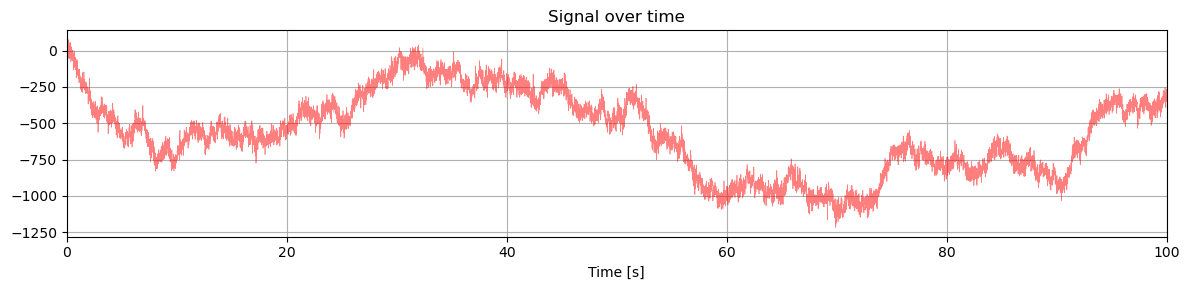

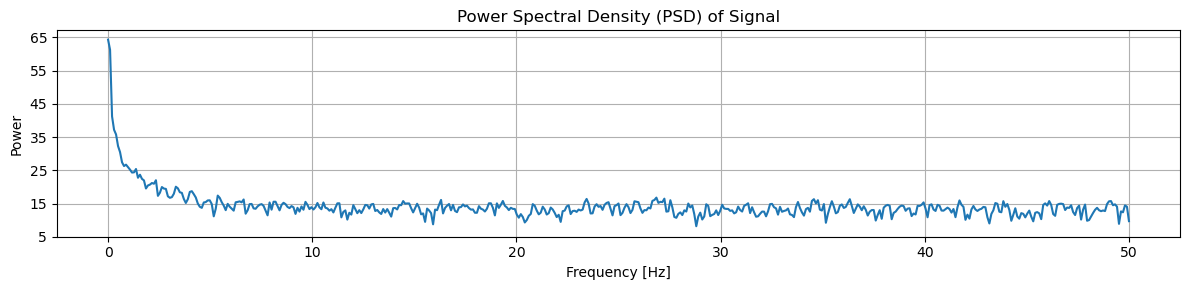

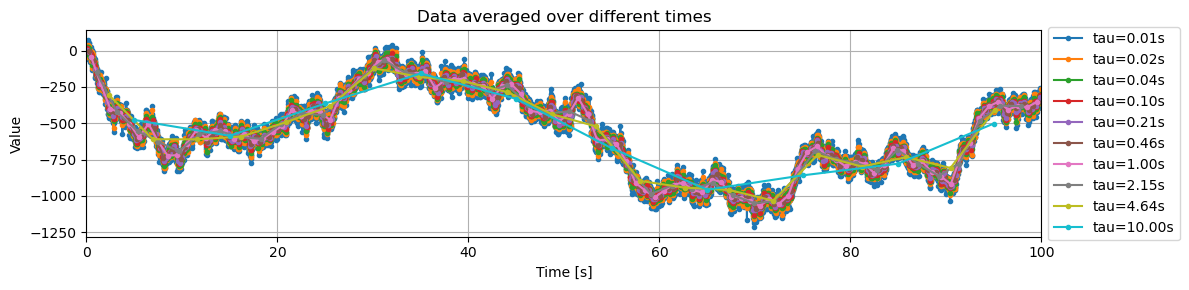

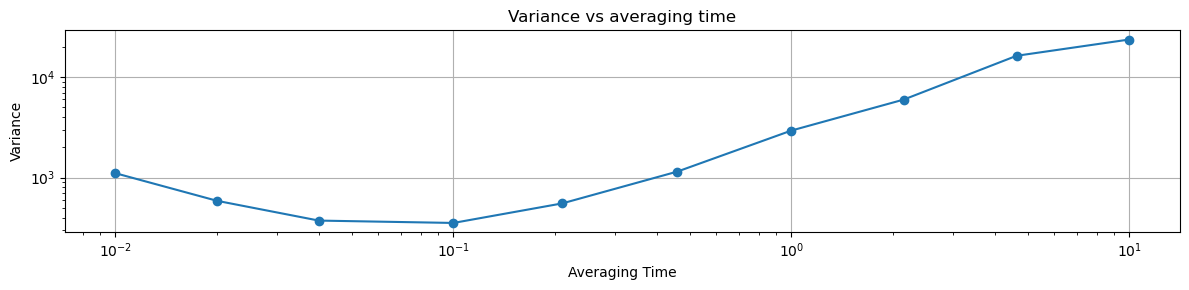

In [98]:
# Parameters for brownian motion
meas_rate = 100 # Rate of measurements in Hz
T_do_not_use = 100 # Total length of signal in s (here for convinience, but do not use after finding N)
N = 1 + int(np.ceil(T_do_not_use*meas_rate)) # Number of measurements (+1 bc t.e. a measurement at 0, too)
linear_drift = 1 # Rate of linear drift of signal
noise_scales = [8, 2, 0] # How much [white, brown, pink] noise

# Make signal
signal = make_signal(noise_scales, linear_drift, N, meas_rate, seed=12)

analyze_signal(signal, meas_rate, 10)

# Application to Measured Signals

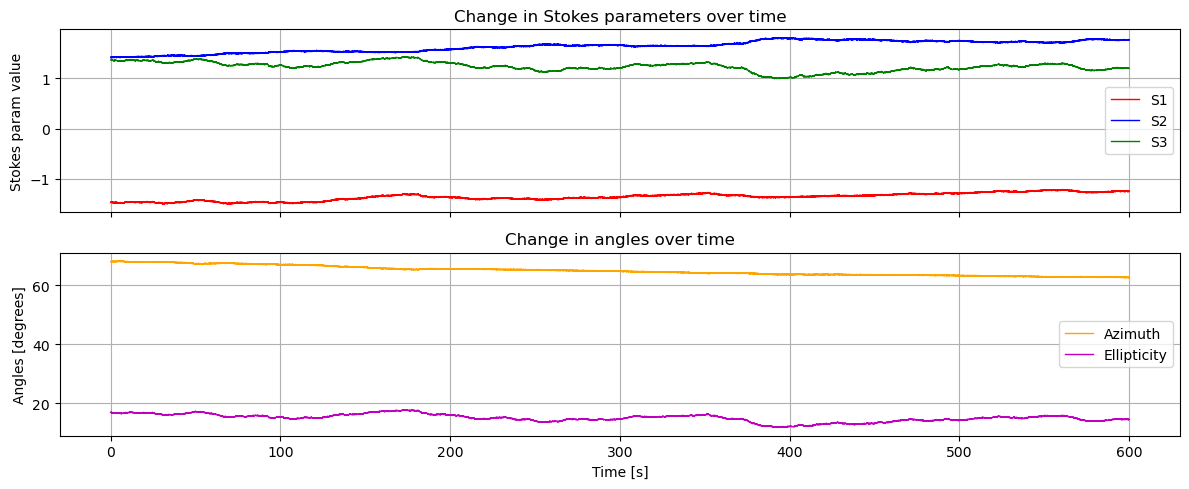

In [133]:
df = df_steady_long
plot_pax_params(df)

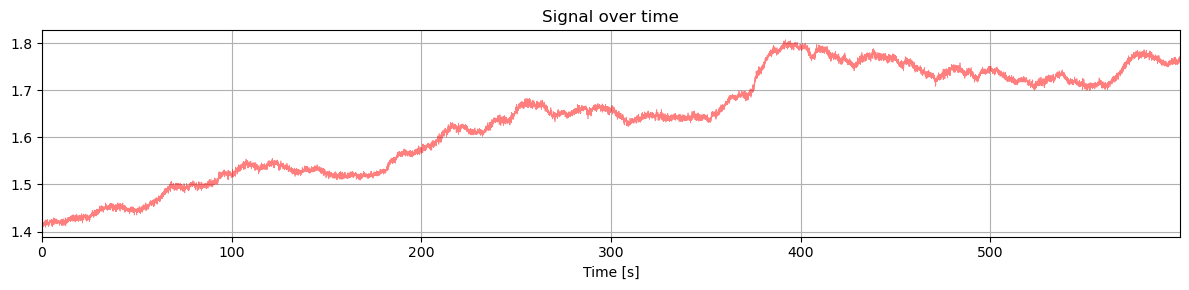

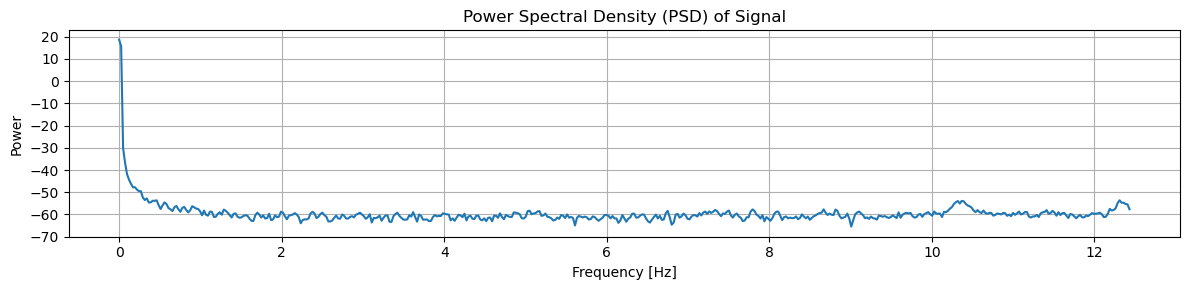

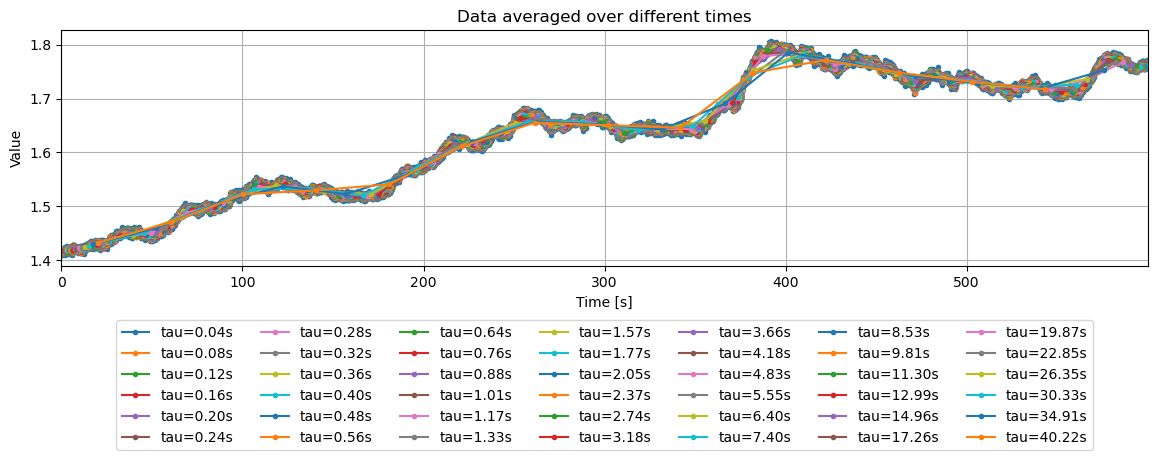

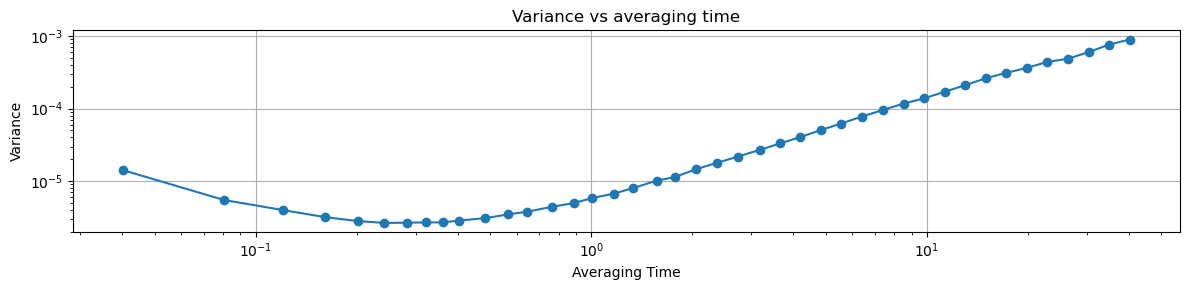

In [143]:
N = df.shape[0]
T = df['TimeElapsed'][N-1]
meas_rate = (N-1)/T

analyze_signal(df['S2'].values, meas_rate, 50)

# Testing

In [ ]:
N = 100000
rate = 100
T = N/rate
noise_std = 0.5  # Standard deviation of the noise

# Generate time axis
t = np.arange(0, T, 1/rate)

# Generate random pink noise
white_noise = np.random.normal(loc=0.0, scale=noise_std, size=N)*np.sqrt(1/N)
brown_noise = np.cumsum(white_noise)
pink_noise = brown_noise - np.linspace(0, brown_noise[-1], num=N)

# Output the time-varying pink noise signal
#plt.plot(pink_noise)

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

# Plot PSD of white noise
axs[0].psd(white_noise, NFFT=1024, Fs=100)
axs[0].set_title('Power Spectral Density (PSD) of White Noise')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Power')
axs[0].grid(True)

# Plot PSD of brown noise
axs[1].psd(brown_noise, NFFT=1024, Fs=100)
axs[1].set_title('Power Spectral Density (PSD) of Brown Noise')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power')
axs[1].grid(True)

# Plot PSD of pink noise
axs[2].psd(pink_noise, NFFT=1024, Fs=100)
axs[2].set_title('Power Spectral Density (PSD) of Pink Noise')
axs[2].set_xlabel('Frequency')
axs[2].set_ylabel('Power')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Plot Added PSDs
plt.figure(figsize=(12,3))
plt.psd(white_noise+brown_noise, NFFT=1024, Fs=meas_rate)
plt.title('Power Spectral Density (PSD) of White and Brown Noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.grid(True)
plt.show()

# Packaged Allan Deviation

In [ ]:
def plot_allan(df):
    meas_rate = df['TimeElapsed'][df.shape[0]-1] #Total seconds elapsed
    meas_rate /= df.shape[0] #divided by total measurements (now is period)
    meas_rate **= -1 #get in Hz
    aDevStokes = [allantools.oadev(df.values[:,i], rate = meas_rate, taus='all', data_type="phase")
               for i in range(5,8)]

    plt.figure(figsize=(12,6))
    labels = ['S1', 'S2', 'S3']
    for i in range(3):
        plt.errorbar(aDevStokes[i][0], aDevStokes[i][1], yerr = aDevStokes[i][2], label = labels[i])
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('Tau [s]')
    plt.ylabel('Deviation [degrees]')
    plt.title('Allan Deviation of Stokes Parameters')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
plot_allan(df_unsteady)

In [ ]:
plot_allan(df_cold)

In [ ]:
def plotallan(plt, y, rate, taus, style):
    (t2, ad, ade, adn) = allantools.oadev(y, rate=rate, data_type="freq", taus=taus)
    plt.loglog(t2, ad, style)


def plotallan_phase(plt, y, rate, taus, style):
    (t2, ad, ade, adn) = allantools.oadev(y, rate=rate, taus=taus)
    plt.loglog(t2, ad, style)


def plotline(plt, alpha, taus, style):
    """ plot a line with the slope alpha """
    y = [pow(tt, alpha) for tt in taus]
    plt.loglog(taus, y, style)

In [ ]:
from allantools import noise

t = np.logspace(0, 3, 50)  # tau values from 1 to 1000
plt.subplot(111, xscale="log", yscale="log")
N = 10000

# # pink frequency noise => constant ADEV
# freq_pink = allantools.noise.pink(N)
# phase_p = np.cumsum(allantools.noise.pink(N))  # integrate to get phase, color??
# (t2, ad, ade, adn) = allantools.oadev(phase_p, rate=1, taus=t)
# plt.loglog(t2, ad, 'co')
# (t2, ad, ade, adn) = allantools.oadev(freq_pink, rate=1, data_type="freq", taus=t)
# plt.loglog(t2, ad, 'c.')
# y = [pow(tt, 0) for tt in t]
# plt.loglog(t, y, 'c')

# pink frequency noise => constant ADEV
freq_pink = noise.pink(N)
phase_p = np.cumsum(noise.pink(N))  # integrate to get phase, color??
plotallan_phase(plt, phase_p, 1, t, 'co')
plotallan(plt, freq_pink, 1, t, 'c.')
plotline(plt, 0, t, 'c')

# white phase noise => 1/tau ADEV
phase_white = noise.white(N)
plotallan_phase(plt, phase_white, 1, t, 'ro')
freq_w = noise.violet(N)  # diff to get frequency, "Violet noise"
plotallan(plt, freq_w, 1, t, 'r.')
plotline(plt, -1, t, 'r')

# white frequency modulation => 1/sqrt(tau) ADEV
freq_white = noise.white(N)
phase_rw = noise.brown(N)  # integrate to get Brownian, or random walk phase
plotallan(plt, freq_white, 1, t, 'b.')
plotallan_phase(plt, phase_rw, 1, t, 'bo')
plotline(plt, -0.5, t, 'b')


# Brownian a.k.a random walk  frequency => sqrt(tau) ADEV
freq_rw = noise.brown(N)
phase_rw_rw = np.cumsum(noise.brown(N))  # integrate to get  phase
plotallan(plt, freq_rw, 1, t, 'm.')
plotallan_phase(plt, phase_rw_rw, 1, t, 'mo')
plotline(plt, +0.5, t, 'm')

plt.xlabel('Tau')
plt.ylabel('Overlapping Allan deviation')
print("Done.")
plt.grid()
plt.show()